In [1]:
import torch
import copy
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor


import matplotlib.pyplot as plt
import numpy as np
import os
import mytools
import pandas as pd


import spconv.pytorch as spconv
from spconv.pytorch import functional as Fsp
from spconv.pytorch.utils import PointToVoxel
from spconv.pytorch.hash import HashTable
import contextlib

# Data Handling

In [2]:
# Read pandas dataframe with all information about sparse training tensors
st_info = pd.read_pickle('/home/majd/sparse_training_tensors/sparse_tensor_info.pk')
st_info.head()

# Make custom dataset
MyDataset = mytools.CustomDataset(dir_loc='/home/majd/sparse_training_tensors/', st_info=st_info)

# Split datat into training, validation, and testing sets
train_dataset, val_dataset = torch.utils.data.random_split(MyDataset,[0.8, 0.2], generator=torch.Generator().manual_seed(42))

print("Training samples: ", len(train_dataset))
print("Validation samples: ", len(val_dataset))

# Create DataLoaders
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


Training samples:  1943113
Validation samples:  485778


In [3]:
# Print tensor shapes
for X_plot, y_plot, offset_plot in train_dataloader:
    print(f"Shape of X [N, C, H, W, D]: {X_plot.shape}")
    print(f"Shape of y: {y_plot.shape} {y_plot.dtype}")
    print("Offsets: ", offset_plot.shape)
    break


Shape of X [N, C, H, W, D]: torch.Size([64, 1, 120, 120, 120])
Shape of y: torch.Size([64, 3]) torch.float32
Offsets:  torch.Size([64, 3])


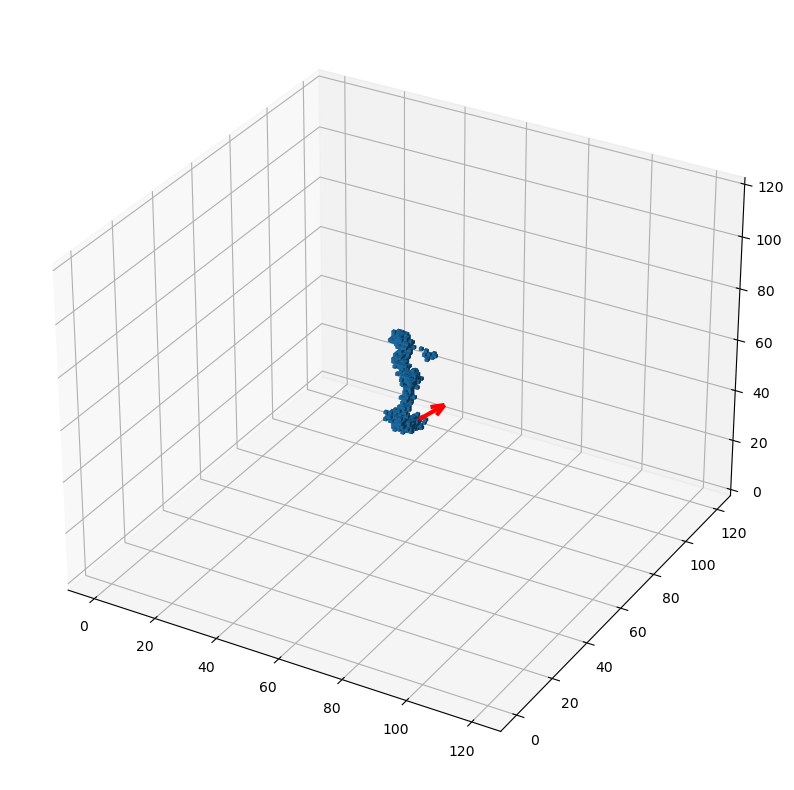

In [4]:
# Plot an example as a sanity check

# x/y/z length being kept in cm
eff_l = 3.0
# Voxel size in cm
vox_l = 0.05

index = 2
mytools.plot_tensor_dir(tensor = X_plot.to_dense().numpy()[index], start = offset_plot[index].numpy(), direction = y_plot[index].numpy(), eff_l=eff_l, vox_l=vox_l)

In [9]:
# Define Loss functions

CS = nn.CosineSimilarity()
def loss_fn_CNN(output, target):
    loss = torch.mean(-1.0*CS(output,target))
    return loss

def loss_fn_HSCDC(output, target):
    loss = torch.mean(-1.0*CS(output[0],target))
    return loss

In [10]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self, shape):
        super(NeuralNetwork, self).__init__()
        self.net = spconv.SparseSequential(
            spconv.SparseConv3d(in_channels=1, out_channels=50, kernel_size=6, stride=2, bias=True),
            nn.ReLU(),
            spconv.SparseMaxPool3d(kernel_size=2, stride=2),
            spconv.SparseConv3d(in_channels=50, out_channels=30, kernel_size=4, stride=1, bias=True),
            nn.ReLU(),
            spconv.SparseConv3d(in_channels=30, out_channels=20, kernel_size=3, stride=1, bias=True),
            nn.ReLU(),
            spconv.SparseMaxPool3d(kernel_size=2, stride=2),
            spconv.ToDense(),
            
        )

        self.fc1 = nn.Linear(12**3 *20, 100)
        self.fc2 = nn.Linear(100, 30)
        self.fc3 = nn.Linear(30, 3)
        
        self.shape = shape
        

    def forward(self, x: torch.Tensor):
        
        x_sp = spconv.SparseConvTensor.from_dense(x.reshape(-1, self.shape[0], self.shape[1], self.shape[2], 1))
        
        
        x = self.net(x_sp)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        output = F.normalize(self.fc3(x),dim=1)
        
        return output

In [12]:
model = torch.load('../3D_Heteroscedastic_Convnet_models/3D_CNN_spconv.pt').to(device)

In [13]:
# Test CNN_spconv

mytools.validate(val_dataloader,model,loss_fn_CNN,device)

Validation loss: -0.902240 



-0.9022404594692124

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=50, kernel_size=6, stride=2)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv3d(in_channels=50, out_channels=30, kernel_size=4, stride=1)
        self.conv3 = nn.Conv3d(in_channels=30, out_channels=20, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(12**3 *20, 100)
        self.fc2 = nn.Linear(100, 30)
        self.fc3 = nn.Linear(30, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = F.normalize(self.fc3(x),dim=1)
        return x



In [15]:
model = torch.load('../3D_Heteroscedastic_Convnet_models/3D_CNN.pt').to(device)

In [16]:
# Test CNN

mytools.validate(val_dataloader,model,loss_fn_CNN,device)

Validation loss: -0.897373 



-0.897372731372877

In [17]:
class NeuralNetwork(nn.Module):
    def __init__(self, shape):
        super(NeuralNetwork, self).__init__()
        self.net = spconv.SparseSequential(
            spconv.SparseConv3d(in_channels=1, out_channels=50, kernel_size=6, stride=2, bias=True),
            nn.ReLU(),
            spconv.SparseMaxPool3d(kernel_size=2, stride=2),
            spconv.SparseConv3d(in_channels=50, out_channels=30, kernel_size=4, stride=1, bias=True),
            nn.ReLU(),
            spconv.SparseConv3d(in_channels=30, out_channels=20, kernel_size=3, stride=1, bias=True),
            nn.ReLU(),
            spconv.SparseMaxPool3d(kernel_size=2, stride=2),
            spconv.ToDense(),
            
        )

        self.fc1 = nn.Linear(12**3 *20, 100)
        self.fc2_1 = nn.Linear(100, 30)
        self.fc3_1 = nn.Linear(30, 3)
        self.fc2_2 = nn.Linear(100, 30)
        self.fc3_2 = nn.Linear(30, 1)
        
        self.shape = shape
        

    def forward(self, x: torch.Tensor):
        
        x_sp = spconv.SparseConvTensor.from_dense(x.reshape(-1, self.shape[0], self.shape[1], self.shape[2], 1))
        
        
        x = self.net(x_sp)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x1 = torch.tanh(self.fc2_1(x))
        output1 = F.normalize(self.fc3_1(x1),dim=1)
        x2 = F.relu(self.fc2_2(x))
        # Training network to predict log(K) is more numerically stable?? 
        output2 = torch.log(F.softplus(self.fc3_2(x2)))
                
        return output1,output2

In [18]:
model = torch.load('../3D_Heteroscedastic_Convnet_models/3D_HSCDC_CNN_spconv.pt').to(device)

In [19]:
# Test HSCDC_spconv
mytools.validate(val_dataloader,model,loss_fn_HSCDC,device)

Validation loss: -0.902090 



-0.9020896169244497

In [20]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=50, kernel_size=6, stride=2)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv3d(in_channels=50, out_channels=30, kernel_size=4, stride=1)
        self.conv3 = nn.Conv3d(in_channels=30, out_channels=20, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(12**3 *20, 100)
        self.fc2_1 = nn.Linear(100, 30)
        self.fc3_1 = nn.Linear(30, 3)
        self.fc2_2 = nn.Linear(100, 30)
        self.fc3_2 = nn.Linear(30, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x1 = torch.tanh(self.fc2_1(x))
        x1 = F.normalize(self.fc3_1(x1),dim=1)
        x2 = F.relu(self.fc2_2(x))
        # Training network to predict log(K) is more numerically stable?? 
        output2 = torch.log(F.softplus(self.fc3_2(x2)))
        return x1,x2



In [21]:
model = torch.load('../3D_Heteroscedastic_Convnet_models/3D_HSCDC_CNN.pt').to(device)

In [22]:
# Test HSCDC

mytools.validate(val_dataloader,model,loss_fn_HSCDC,device)

Validation loss: -0.895717 



-0.8957165689701432